导入程序包

In [164]:
import numpy as np
import librosa
import librosa.display 
import datetime
import matplotlib.pyplot as plt
from torch.nn.functional import binary_cross_entropy_with_logits, mse_loss
from torchvision import datasets, transforms
from IPython.display import clear_output
import torchvision
#from torchvision.datasets.vision import VisionDataset
from torch.optim import Adam
from tqdm import notebook
import torch
import os.path
import os
import gc
import sys
from PIL import ImageFile, Image
from torchaudio import transforms as audiotransforms
import torchaudio
import soundfile 
from IPython.display import Audio
import random
import skimage
from skimage import transform
from collections import Counter
import soundfile

from SSIM import *
from critic import *
from decoder import *
from encoder import *
from loader import *

ImageFile.LOAD_TRUNCATED_IMAGES = True


from torch.utils.tensorboard import SummaryWriter
# %load_ext tensorboard 

# to watch previous logs please change the path to the folder logs are stored into

current_time = datetime.datetime.now().strftime('%b%d_%H-%M-%S')
log_dir = os.path.join('results/runs', current_time )
os.makedirs(log_dir, exist_ok=True)
# %tensorboard --logdir {log_dir}


epochs = 32
data_depth = 4
hidden_size = 32
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
LOAD_MODEL = True
# PATH='audio_models\DenseEncoder_DenseDecoder_+0.686_2020-07-28_13_39_35.dat'
PATH='audio_models\DenseEncoder_DenseDecoder_+0.774_2020-07-28_15_51_10.dat'
audio = True

相关函数定义：

In [165]:
def plot(name, train_epoch, values, path, save):
    clear_output(wait=True)
    plt.close('all')
    fig = plt.figure()
    fig = plt.ion()
    fig = plt.subplot(1, 1, 1)
    fig = plt.title('epoch: %s -> %s: %s' % (train_epoch, name, values[-1]))
    fig = plt.ylabel(name)
    fig = plt.xlabel('validation_set')
    fig = plt.plot(values)
    fig = plt.grid()
    get_fig = plt.gcf()
    fig = plt.draw()  # draw the plot
    fig = plt.pause(1)  # show it for 1 second
#     if save:
#         now = datetime.datetime.now()
#         get_fig.savefig('%s/%s_%.3f_%d_%s.png' %
#                         (path, name, train_epoch, values[-1], now.strftime("%Y-%m-%d_%H:%M:%S")))


def test(encoder,decoder,data_depth,train_epoch,cover,payload):
  # %matplotlib inline
  generated = encoder.forward(cover, payload)
  decoded = decoder.forward(generated)
  decoder_loss = binary_cross_entropy_with_logits(decoded, payload)
  decoder_acc = (decoded >= 0.0).eq(
    payload >= 0.5).sum().float() / payload.numel() # .numel() calculate the number of element in a tensor
  print("Decoder loss: %.3f"% decoder_loss.item())
  print("Decoder acc: %.3f"% decoder_acc.item())
  f, ax = plt.subplots(1, 3)
  f.suptitle("%s_%s"%(encoder.name,decoder.name), fontsize=16)
  cover_=np.transpose(np.squeeze(cover.cpu()), (1, 2, 0))
  ax[0].imshow(cover_)
  ax[0].invert_yaxis()
  ax[0].axis('off')
  ax[0].set_title('Cover image')
  generated_=np.transpose(np.squeeze((generated.cpu()).detach().numpy()), (1, 2, 0))
  ax[1].imshow(generated_)
  ax[1].invert_yaxis()
  ax[1].axis('off')
  ax[1].set_title('Generated image')
  payload=cover_-generated_
  ax[2].imshow(payload)
  ax[2].invert_yaxis()
  ax[2].axis('off')
  ax[2].set_title('Generated payload')
  return generated


def save_model(encoder,decoder,critic,en_de_optimizer,cr_optimizer,metrics,ep):
    now = datetime.datetime.now()
    cover_score = metrics['val.decoder_acc'][-1]
    name = "%s_%s_%+.3f_%s.dat" % (encoder.name,decoder.name,cover_score,
                                   now.strftime("%Y-%m-%d_%H:%M:%S"))
    fname = os.path.join('.', 'results/model', name)
    states = {
            'state_dict_critic': critic.state_dict(),
            'state_dict_encoder': encoder.state_dict(),
            'state_dict_decoder': decoder.state_dict(),
            'en_de_optimizer': en_de_optimizer.state_dict(),
            'cr_optimizer': cr_optimizer.state_dict(),
            'metrics': metrics,
            'train_epoch': ep,
            'date': now.strftime("%Y-%m-%d_%H:%M:%S"),
    }
    torch.save(states, fname)


def fit_gan(encoder,decoder,critic,en_de_optimizer,cr_optimizer,metrics,train_loader,valid_loader):
      iter_train_critic=0
      iter_train_enc_dec=0
      iter_valid=0
      writer = SummaryWriter()
      for ep in range(epochs):
        print("Epoch %d" %(ep+1))
        for cover, *rest in notebook.tqdm(train_loader):
            if torch.cuda.is_available():
              cover = cover.cuda()
            iter_train_critic+=1
            gc.collect()
            cover = cover.to(device)
            N, _, H, W = cover.size()
            # sampled from the discrete uniform distribution over 0 to 2
            payload = torch.zeros((N, data_depth, H, W),
                                  device=device).random_(0, 2)
            generated = encoder.forward(cover, payload)
            cover_score = torch.mean(critic.forward(cover))
            generated_score = torch.mean(critic.forward(generated))

            cr_optimizer.zero_grad()
            (cover_score - generated_score).backward(retain_graph=False)
            cr_optimizer.step()
            
            for p in critic.parameters():
                p.data.clamp_(-0.1, 0.1)
            writer.add_scalar('cover_score/train', cover_score.item(), iter_train_critic)
            writer.add_scalar('generated_score/train', generated_score.item(), iter_train_critic)

            metrics['train.cover_score'].append(cover_score.item())
            metrics['train.generated_score'].append(generated_score.item())
              
            for tag, value in critic.named_parameters():
              tag = tag.replace('.', '/')
              writer.add_histogram('critic/'+tag, value.data.cpu().numpy(), iter_train_critic)
              writer.add_histogram('critic/'+tag+'/grad', value.grad.data.cpu().numpy(), iter_train_critic)

        for cover, *rest in notebook.tqdm(train_loader):
            if torch.cuda.is_available():
              cover = cover.cuda()
            iter_train_enc_dec+=1
            gc.collect()
            cover = cover.to(device)
            N, _, H, W = cover.size()
            # sampled from the discrete uniform distribution over 0 to 2
            payload = torch.zeros((N, data_depth, H, W),
                                  device=device).random_(0, 2)
            generated = encoder.forward(cover, payload)
            decoded = decoder.forward(generated)
            encoder_mse = mse_loss(generated, cover)
            decoder_loss = binary_cross_entropy_with_logits(decoded, payload)
            decoder_acc = (decoded >= 0.0).eq(
                payload >= 0.5).sum().float() / payload.numel()
            generated_score = torch.mean(critic.forward(generated))

            en_de_optimizer.zero_grad()
            (100 * encoder_mse + decoder_loss +
             generated_score).backward()  # Why 100?
            en_de_optimizer.step()

            writer.add_scalar('encoder_mse/train', encoder_mse.item(), iter_train_enc_dec)
            writer.add_scalar('decoder_loss/train', decoder_loss.item(), iter_train_enc_dec)
            writer.add_scalar('decoder_acc/train', decoder_acc.item(), iter_train_enc_dec)

            metrics['train.encoder_mse'].append(encoder_mse.item())
            metrics['train.decoder_loss'].append(decoder_loss.item())
            metrics['train.decoder_acc'].append(decoder_acc.item())

            for tag, value in encoder.named_parameters():
              tag = tag.replace('.', '/')
              writer.add_histogram('encoder/'+tag, value.data.cpu().numpy(), iter_train_enc_dec)
              writer.add_histogram('encoder/'+tag+'/grad', value.grad.data.cpu().numpy(), iter_train_enc_dec)

            for tag, value in decoder.named_parameters():
              tag = tag.replace('.', '/')
              writer.add_histogram('decoder/'+tag, value.data.cpu().numpy(), iter_train_enc_dec)
              writer.add_histogram('decoder/'+tag+'/grad', value.grad.data.cpu().numpy(), iter_train_enc_dec)
            
        for cover, *rest in notebook.tqdm(valid_loader):
            if torch.cuda.is_available():
              cover = cover.cuda()
            iter_valid+=1
            gc.collect()
            cover = cover.to(device)
            
            N, _, H, W = cover.size()
            # sampled from the discrete uniform distribution over 0 to 2
            payload = torch.zeros((N, data_depth, H, W),
                                  device=device).random_(0, 2)
            generated = encoder.forward(cover, payload)

            decoded = decoder.forward(generated)

            encoder_mse = mse_loss(generated, cover)
            decoder_loss = binary_cross_entropy_with_logits(decoded, payload)
            decoder_acc = (decoded >= 0.0).eq(
                payload >= 0.5).sum().float() / payload.numel()
            generated_score = torch.mean(critic.forward(generated))
            cover_score = torch.mean(critic.forward(cover))

            ssim_=ssim(cover, generated)
            psnr_=10 * torch.log10(4 / encoder_mse)
            bbp_=data_depth * (2 * decoder_acc.item() - 1)

            writer.add_scalar('encoder_mse/test', encoder_mse.item(), iter_valid)
            writer.add_scalar('decoder_loss/test', decoder_loss.item(), iter_valid)
            writer.add_scalar('decoder_acc/test', decoder_acc.item(), iter_valid)
            writer.add_scalar('cover_score/test', cover_score.item(), iter_valid)
            writer.add_scalar('generated_score/test', generated_score.item(), iter_valid)
            writer.add_scalar('ssim/test', ssim_.item(), iter_valid)
            writer.add_scalar('psnr/test', psnr_.item(), iter_valid)
            writer.add_scalar('bbp/test',bbp_, iter_valid)

            metrics['val.encoder_mse'].append(encoder_mse.item())
            metrics['val.decoder_loss'].append(decoder_loss.item())
            metrics['val.decoder_acc'].append(decoder_acc.item())
            metrics['val.cover_score'].append(cover_score.item())
            metrics['val.generated_score'].append(generated_score.item())
            metrics['val.ssim'].append(ssim_.item())
            metrics['val.psnr'].append(psnr_.item())
            metrics['val.bpp'].append(bbp_)

        if audio:
          writer.add_image('cover/test', torch.tensor(np.abs(cover[:,0,:,:].cpu().detach().numpy()+1j*cover[:,1,:,:].cpu().detach().numpy())).unsqueeze(0), ep, dataformats='CNHW')
          writer.add_image('generated/test', torch.tensor(np.abs(generated[:,0,:,:].cpu().detach().numpy()+1j*generated[:,1,:,:].cpu().detach().numpy())).unsqueeze(0), ep, dataformats='CNHW')
          writer.add_image('payload/test', torch.tensor(np.abs((cover[:,0,:,:].cpu().detach().numpy()+1j*cover[:,1,:,:].cpu().detach().numpy())-(generated[:,0,:,:].cpu().detach().numpy()+1j*generated[:,1,:,:].cpu().detach().numpy()))).unsqueeze(0), ep, dataformats='CNHW')
        else:
          writer.add_image('cover/test', cover, ep, dataformats='NCHW')
          writer.add_image('generated/test', generated, ep, dataformats='NCHW')
          writer.add_image('payload/test', cover-generated, ep, dataformats='NCHW')

        print('encoder_mse: %.3f - decoder_loss: %.3f - decoder_acc: %.3f - cover_score: %.3f - generated_score: %.3f - ssim: %.3f - psnr: %.3f - bpp: %.3f'
          %(encoder_mse.item(),decoder_loss.item(),decoder_acc.item(),cover_score.item(),generated_score.item(), ssim_.item(),psnr_.item(),bbp_))
      
        save_model(encoder,decoder,critic,en_de_optimizer,cr_optimizer,metrics,ep)
        
      writer.add_graph(encoder,(cover, payload))
      writer.add_graph(decoder,generated)
      writer.add_graph(critic,generated)
      writer.close()


def make_payload(width, height, depth, text):
    """
    This takes a piece of text and encodes it into a bit vector. It then
    fills a matrix of size (width, height) with copies of the bit vector.
    """
    message = text_to_bits(text) + [0] * 32

    payload = message
    while len(payload) < width * height * depth:
        payload += message

    payload = payload[:width * height * depth]

    return torch.FloatTensor(payload).view(1, depth, height, width)

def make_message(image):
    image = image.to(device)
    
    image = decoder(image).view(-1) > 0
    image=torch.tensor(image, dtype=torch.uint8)

    # split and decode messages
    candidates = Counter()
    bits = image.data.cpu().numpy().tolist()
    for candidate in bits_to_bytearray(bits).split(b'\x00\x00\x00\x00'):
      #print(candidate)
      candidate = bytearray_to_text(bytearray(candidate))
      if candidate:
          candidates[candidate] += 1

    # choose most common message
    if len(candidates) == 0:
      raise ValueError('Failed to find message.')

    candidate, count = candidates.most_common(1)[0]
    return candidate


def plot_audio(mel):
  fig, ax = plt.subplots()
  img = librosa.display.specshow(mel, x_axis='time', fmin=0,fmax=6000,
                          y_axis='mel', sr=6000, ax=ax)
  fig.colorbar(img, ax=ax,format='%+2.0f dB')


def test_audio(encoder,decoder,data_depth,train_epoch,cover,payload):
  # %matplotlib inline
  generated = encoder.forward(cover, payload)
  decoded = decoder.forward(generated)
  decoder_loss = binary_cross_entropy_with_logits(decoded, payload)
  decoder_acc = (decoded >= 0.0).eq(
    payload >= 0.5).sum().float() / payload.numel() # .numel() calculate the number of element in a tensor
  print("Decoder loss: %.3f"% decoder_loss.item())
  print("Decoder acc: %.3f"% decoder_acc.item())
  f, ax = plt.subplots(1, 3,figsize=(16,5))
  f.suptitle("%s_%s"%(encoder.name,decoder.name), fontsize=16)
  f.tight_layout(pad=4.0)
  if len(cover.shape)==4:
    cover_=cover.squeeze(0).cpu().detach().numpy()
  else:
    cover_=cover.cpu().detach().numpy()
  cover_spec=cover_[0]+1j*cover_[1]
  librosa.display.specshow(cover_spec, x_axis='time', fmin=0,fmax=22050,
                          y_axis='mel', sr=22050, ax=ax[0])
  ax[0].set_title('Cover image')
  if len(generated.shape)==4:
    generated_=generated.squeeze(0).cpu().detach().numpy()
  else:
    generated_=generated.cpu().detach().numpy()
  generated_spec=generated_[0]+1j*generated_[1]
  librosa.display.specshow(generated_spec, x_axis='time', fmin=0,fmax=22050,
                          y_axis='mel', sr=22050, ax=ax[1])
  ax[1].set_title('Generated image')
  payload_=cover_spec-generated_spec
  img=librosa.display.specshow(payload_, x_axis='time', y_axis='mel', fmin=0,fmax=22050,
                           sr=22050, ax=ax[2])
  ax[2].set_title('Generated payload')

  return generated


def aud_to_melspectro(wav):
   wav=wav[0]
   len_=wav.shape[0]
   hop_length_=int(len_/(360-1))
   n_fft_=int((360-1)*2)
   mel=librosa.stft(np.asarray(wav),n_fft=n_fft_, hop_length=hop_length_)
   H_,W_=mel.shape
   mel_real=np.real(mel)
   mel_imag=np.imag(mel)
   if not mel_real.shape == (360,360):
      mel_real=skimage.transform.resize(image=mel_real,output_shape=(360,360),order=1)
   if not mel_imag.shape == (360,360):
      mel_imag=skimage.transform.resize(image=mel_imag,output_shape=(360,360),order=1)
   return torch.tensor([mel_real,mel_imag]).float(), hop_length_

导入预训练模型并进行测试：

In [260]:
if __name__ == '__main__':
  for func in [
            lambda: os.mkdir(os.path.join('.', 'results')),
            lambda: os.mkdir(os.path.join('.', 'results/model')),
            lambda: os.mkdir(os.path.join('.', 'results/plots'))]:  # create directories
    try:
      func()
    except Exception as error:
      print(error)
      continue

  METRIC_FIELDS = [
        'val.encoder_mse',
        'val.decoder_loss',
        'val.decoder_acc',
        'val.cover_score',
        'val.generated_score',
        'val.ssim',
        'val.psnr',
        'val.bpp',
        'train.encoder_mse',
        'train.decoder_loss',
        'train.decoder_acc',
        'train.cover_score',
        'train.generated_score',
  ]

  writer = SummaryWriter(log_dir)
  print('Tensorboard logs stored in: ',writer.get_logdir())

  if audio:
    print('audio')
    data_dir="FSDKaggle2018"#"genres"#"music_speech" # directory to audio
    channels_size=2
    transform = transforms.Compose([transforms.Lambda(lambda wav: aud_to_melspectro(wav))])
    train_set = AudioToImageFolder(os.path.join(
          data_dir, "train\\"), transform=transform)
    part_train_set = torch.utils.data.random_split(train_set, [800, len(train_set)-800])[0]
    train_loader = torch.utils.data.DataLoader(
          part_train_set, batch_size=4, shuffle=True,)
    valid_set = AudioToImageFolder(os.path.join( 
          data_dir, "val\\"), transform=transform)
    part_valid_set = torch.utils.data.random_split(valid_set, [100, len(valid_set)-100])[0]
    valid_loader = torch.utils.data.DataLoader(
          part_valid_set, batch_size=4, shuffle=True)
  else:
    print('image')
    data_dir = 'div2k'
    mu = [.5, .5, .5]
    sigma = [.5, .5, .5]
    channels_size=3
    transform = transforms.Compose([transforms.RandomHorizontalFlip(),
                                      transforms.RandomCrop(
                                          360, pad_if_needed=True),
                                      transforms.ToTensor(),
                                      transforms.Normalize(mu, sigma)])
    train_set = datasets.ImageFolder(os.path.join(
          data_dir, "train/"), transform=transform)
    train_loader = torch.utils.data.DataLoader(
          train_set, batch_size=4, shuffle=True)
    valid_set = datasets.ImageFolder(os.path.join( 
          data_dir, "val/"), transform=transform)
    valid_loader = torch.utils.data.DataLoader(
          valid_set, batch_size=4, shuffle=False)

  encoder = DenseEncoder(data_depth, hidden_size,channels_size).to(device)
  decoder = DenseDecoder(data_depth, hidden_size,channels_size).to(device)
  critic = BasicCritic(hidden_size,channels_size).to(device)
  cr_optimizer = Adam(critic.parameters(), lr=1e-4)
  en_de_optimizer = Adam(list(decoder.parameters()) + list(encoder.parameters()), lr=1e-4)
  metrics = {field: list() for field in METRIC_FIELDS}

  if LOAD_MODEL: 
    if torch.cuda.is_available():
      checkpoint = torch.load(PATH)
    else:
      checkpoint = torch.load(PATH, map_location=lambda storage, loc: storage)
              
    critic.load_state_dict(checkpoint['state_dict_critic'])
    encoder.load_state_dict(checkpoint['state_dict_encoder'])
    decoder.load_state_dict(checkpoint['state_dict_decoder'])
    en_de_optimizer.load_state_dict(checkpoint['en_de_optimizer'])
    cr_optimizer.load_state_dict(checkpoint['cr_optimizer'])
    metrics=checkpoint['metrics']
    ep=checkpoint['train_epoch']
    date=checkpoint['date']
    critic.train(mode=False)
    encoder.train(mode=False)
    decoder.train(mode=False)
  else:
    fit_gan(encoder,decoder,critic,en_de_optimizer,cr_optimizer,metrics,train_loader,valid_loader)

[WinError 183] 当文件已存在时，无法创建该文件。: '.\\results'
[WinError 183] 当文件已存在时，无法创建该文件。: '.\\results/model'
[WinError 183] 当文件已存在时，无法创建该文件。: '.\\results/plots'
Tensorboard logs stored in:  results/runs\Jan11_21-28-54
audio


进行隐写测试：

Decoder loss: 0.389
Decoder acc: 0.801


C:\Users\Fsadness\AppData\Local\Temp\ipykernel_55488\2659723657.py:231: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image=torch.tensor(image, dtype=torch.uint8)


Message found:  Lorem ipsum


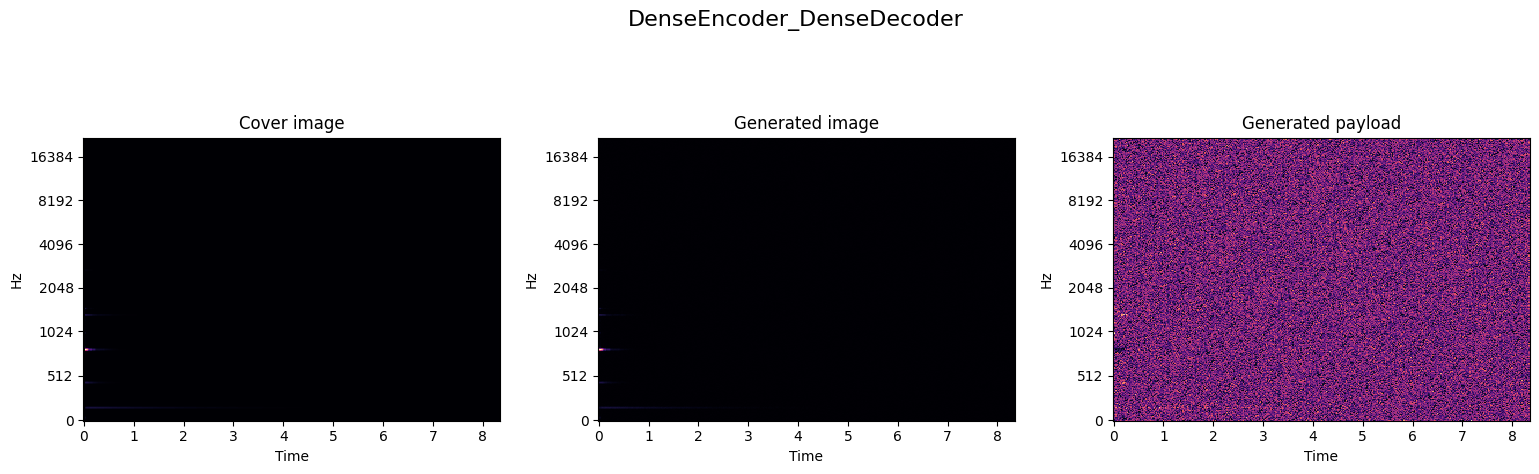

In [456]:
if audio:
  cover, path, hop_length = valid_set[106]
else:
  cover, *rest = next(iter(valid_set))

_, H, W = cover.size()
cover = cover[None].to(device)

text = "Lorem ipsum"
payload = make_payload(W, H, data_depth, text)
payload = payload.to(device)
if audio:
  generated = test_audio(encoder,decoder,data_depth,epochs,cover,payload)
else:
  generated = test(encoder,decoder,data_depth,epochs,cover,payload)

text_return_ = make_message(generated)

print('Message found: ',text_return_)

隐写前后音频试听：

In [487]:
Audio(path, autoplay=True) # ORIGINAL AUDIO

In [488]:
generated_=generated.squeeze(0).cpu().detach().numpy()
mel_rec=generated_[0]+1j*generated_[1]
print(mel_rec.shape)
aud=librosa.istft(mel_rec, hop_length=hop_length)
print(aud.shape)
soundfile.write('test.wav', aud, samplerate=22050*2)

Audio('test.wav', autoplay=True) # GENERATED

(360, 360)
(267096,)


Text(0.5, 1.0, 'Generated payload storaged')

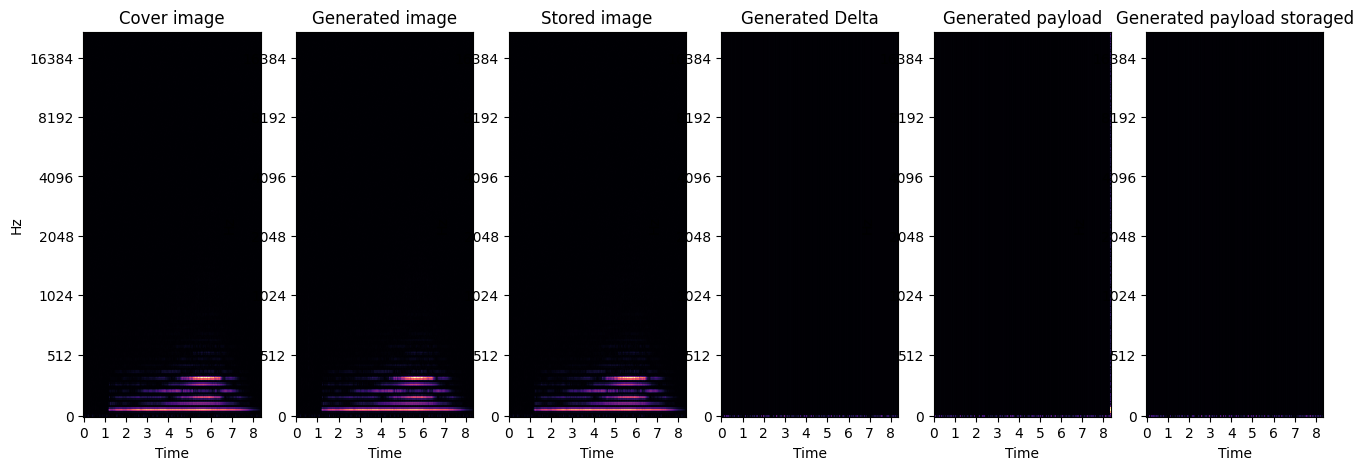

In [463]:
f, ax = plt.subplots(1, 6,figsize=(16,5))
cover_=cover.squeeze(0).cpu().detach().numpy()
cover_spec=cover_[0]+1j*cover_[1]
librosa.display.specshow(cover_spec, x_axis='time', fmin=0,fmax=22050,
                          y_axis='mel', sr=22050, ax=ax[0])
ax[0].set_title('Cover image')

generated_=generated.squeeze(0).cpu().detach().numpy()
generated_spec=generated_[0]+1j*generated_[1]
librosa.display.specshow(generated_spec, x_axis='time', fmin=0,fmax=22050,
                        y_axis='mel', sr=22050, ax=ax[1])
ax[1].set_title('Generated image')

# wav, sr = librosa.load("test.wav",sr=22050)
# len_=wav.shape[0]
# hop_length_=int(len_/(360-1))
# n_fft_=int((360-1)*2)
# mel=librosa.stft(np.asarray(wav),n_fft=n_fft_, hop_length=hop_length)
aud1=librosa.istft(mel_rec, hop_length=hop_length)
mel=librosa.stft(aud1,n_fft=int((360-1)*2), hop_length=hop_length)
librosa.display.specshow(mel, x_axis='time', fmin=0,fmax=22050,
                        y_axis='mel', sr=22050, ax=ax[2])
ax[2].set_title('Stored image')

delta = generated_spec - mel
img=librosa.display.specshow(delta, x_axis='time', y_axis='mel', fmin=0,fmax=22050,
                            sr=22050, ax=ax[3])
ax[3].set_title('Generated Delta')

payload_=cover_spec-generated_spec
img=librosa.display.specshow(payload_, x_axis='time', y_axis='mel', fmin=0,fmax=22050,
                           sr=22050, ax=ax[4])
ax[4].set_title('Generated payload')

payload1_=cover_spec-mel
img=librosa.display.specshow(payload_, x_axis='time', y_axis='mel', fmin=0,fmax=22050,
                           sr=22050, ax=ax[5])
ax[5].set_title('Generated payload storaged')

In [399]:
# wav, sr = librosa.load("test.wav",sr=22050)
# len_=wav.shape[0]
# hop_length_=int(len_/(360-1))
# n_fft_=int((360-1)*2)
# mel=librosa.stft(np.asarray(wav),n_fft=n_fft_, hop_length=hop_length)
mel=librosa.stft(aud,n_fft=int((360-1)*2), hop_length=hop_length)
H_,W_=mel.shape
mel_real=np.real(mel)
mel_imag=np.imag(mel)
if not mel_real.shape == (360,360):
    mel_real=skimage.transform.resize(image=mel_real,output_shape=(360,360),order=1)
if not mel_imag.shape == (360,360):
    mel_imag=skimage.transform.resize(image=mel_imag,output_shape=(360,360),order=1)
cover=torch.reshape(torch.tensor([mel_real,mel_imag]), [1, 2, 360, 360])
#print(cover.shape)
text_return_ = make_message(cover)

print('Message found: ',text_return_)

C:\Users\Fsadness\AppData\Local\Temp\ipykernel_55488\2659723657.py:231: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image=torch.tensor(image, dtype=torch.uint8)


ValueError: Failed to find message.

In [358]:
wav, sr = librosa.load("test.wav",sr=22050)
len_=wav.shape[0]
hop_length_=int(len_/(360-1))
n_fft_=int((360-1)*2)
mel=librosa.stft(np.asarray(wav),n_fft=n_fft_, hop_length=hop_length_)
H_,W_=mel.shape
mel_real=np.real(mel)
mel_imag=np.imag(mel)
if not mel_real.shape == (360,360):
    mel_real=skimage.transform.resize(image=mel_real,output_shape=(360,360),order=1)
if not mel_imag.shape == (360,360):
    mel_imag=skimage.transform.resize(image=mel_imag,output_shape=(360,360),order=1)
cover=torch.tensor([mel_real,mel_imag])
#print(cover.shape)
text_return_ = make_message(cover[None])

print('Message found: ',text_return_)

C:\Users\Fsadness\AppData\Local\Temp\ipykernel_55488\2659723657.py:231: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image=torch.tensor(image, dtype=torch.uint8)


Message found:  Lorem ipsum


Decoder loss: 0.425
Decoder acc: 0.771
(360, 360)
(267096,)


C:\Users\Fsadness\AppData\Local\Temp\ipykernel_55488\2659723657.py:231: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image=torch.tensor(image, dtype=torch.uint8)


Message found:  Lorem ipsum


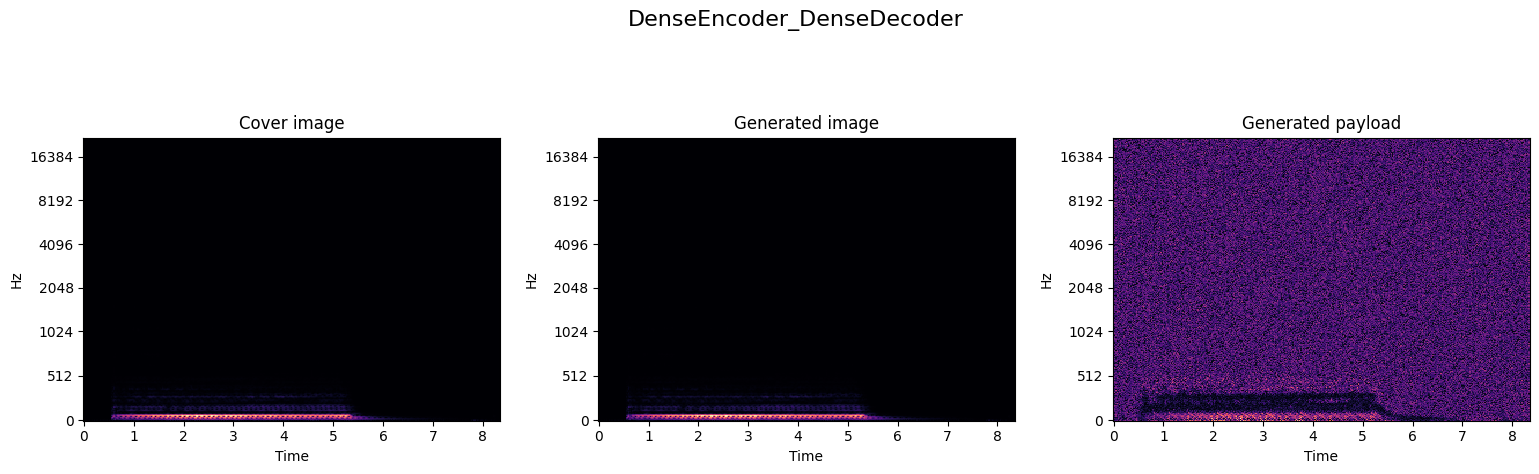

In [486]:
if audio:
  cover, path, hop_length = valid_set[140]
else:
  cover, *rest = next(iter(valid_set))

_, H, W = cover.size()
cover = cover[None].to(device)

text = "Lorem ipsum"
payload = make_payload(W, H, data_depth, text)
payload = payload.to(device)
if audio:
  generated = test_audio(encoder,decoder,data_depth,epochs,cover,payload)
else:
  generated = test(encoder,decoder,data_depth,epochs,cover,payload)


generated_=generated.squeeze(0).cpu().detach().numpy()
mel_rec=generated_[0]+1j*generated_[1]
print(mel_rec.shape)
aud=librosa.istft(mel_rec, hop_length=hop_length)
print(aud.shape)
soundfile.write('test.wav', aud, samplerate=22050*2)

Audio('test.wav', autoplay=True) # GENERATED

# wav, sr = librosa.load("test.wav",sr=22050)
# len_=wav.shape[0]
# hop_length_=int(len_/(360-1))
# n_fft_=int((360-1)*2)
# mel=librosa.stft(np.asarray(wav),n_fft=n_fft_, hop_length=hop_length)
mel=librosa.stft(aud,n_fft=int((360-1)*2), hop_length=hop_length)
H_,W_=mel.shape
mel_real=np.real(mel)
mel_imag=np.imag(mel)
if not mel_real.shape == (360,360):
    mel_real=skimage.transform.resize(image=mel_real,output_shape=(360,360),order=1)
if not mel_imag.shape == (360,360):
    mel_imag=skimage.transform.resize(image=mel_imag,output_shape=(360,360),order=1)
cover=torch.reshape(torch.tensor([mel_real,mel_imag]), [1, 2, 360, 360])
#print(cover.shape)
text_return_ = make_message(cover)

print('Message found: ',text_return_)